In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.backend import squeeze
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dropout, Input
from tensorflow.keras.layers import (
     Conv1D, Conv2D, Dense, MaxPooling2D, MaxPooling1D, AveragePooling2D, AveragePooling1D, Flatten, Reshape
)
from tensorflow.keras import optimizers

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

data = pd.read_csv('../ReducedData/ReturnTrainingData/FullTeamReturn.csv')
train_tensor_field = np.zeros((len(data),10,11,7))
norm_stats = np.zeros((train_tensor_field.shape[-1],2))

output_values = np.arcsinh(data['dx'])#data[['dx','dy','dFrame']].values

In [233]:
def shuffle_players(df):
    temp = np.concatenate((df.iloc[:,:-1:2].values[...,np.newaxis],df.iloc[:,1::2].values[...,np.newaxis]),axis=2)
    [np.random.shuffle(x) for x in temp]
    return pd.DataFrame(temp.reshape(temp.shape[0],-1),columns=df.columns)


data.iloc[:,5:25] = shuffle_players(data.iloc[:,5:25])
data.iloc[:,25:47] = shuffle_players(data.iloc[:,25:47])


fb_x = data.iloc[:,[47,49]]
fb_y = data.iloc[:,[48,50]]

punter = data.iloc[:,3:5]

punt_team_x = data.iloc[:,5:24:2]
punt_team_y = data.iloc[:,6:25:2]

ret_team_x = data.iloc[:,25:46:2]
ret_team_y = data.iloc[:,26:47:2]

In [234]:
def diff_coord(team1, team2):
    t1 = team1.stack().reset_index()
    t2 = team2.stack().reset_index()
    t1xt2 = t1.merge(t2,on='level_0')
    t1xt2['diff'] = t1xt2['0_y'] - t1xt2['0_x']
    return t1xt2.set_index(['level_0','level_1_y','level_1_x'])['diff']


# Find X and Y displacements for each combination of punt and return team players
train_tensor_field[:,:,:,0] = diff_coord(ret_team_x,punt_team_x).unstack().values.reshape(len(data),10,11)
train_tensor_field[:,:,:,1] = diff_coord(ret_team_y,punt_team_y).unstack().values.reshape(len(data),10,11)

# Find X and Y displacement between Punter and Return Team players
train_tensor_field[:,:,:,2] = np.tile((-ret_team_x.sub(punter['x_punt'],axis=0).values)[:,np.newaxis],(1,10,1))
train_tensor_field[:,:,:,3] = np.tile((-ret_team_y.sub(punter['y_punt'],axis=0).values)[:,np.newaxis],(1,10,1))

# Find X and Y displacement between Return Team players and the football landing location
train_tensor_field[:,:,:,4] = np.tile((-punt_team_x.sub(fb_x['x_land'],axis=0).values)[:,:,np.newaxis],11)
train_tensor_field[:,:,:,5] = np.tile((-punt_team_y.sub(fb_y['y_land'],axis=0).values)[:,:,np.newaxis],11)

# Insert constant data for final three features
# train_tensor_field[:,:,:,6] = np.tile(data['x_fb'].values,(11,10,1)).T
# train_tensor_field[:,:,:,7] = np.tile(data['y_fb'].values,(11,10,1)).T
train_tensor_field[:,:,:,6] = np.tile(data['hangTime'].values,(11,10,1)).T

In [235]:
for i in range(train_tensor_field.shape[-1]):
    if norm_stats[i].sum()==0:
        norm_stats[i] = np.array([train_tensor_field[...,i].mean(),train_tensor_field[...,i].std()])

In [237]:
def create_NN_field(drop_rate=0.2, learning_rate=0.001):
    feature_input = Input(shape=(10,11,7), name='positional')
    
    x = Conv2D(8, kernel_size=(1,1), activation='elu')(feature_input)
    x = Conv2D(2, kernel_size=(1,1), activation='elu')(x)

    x1 = MaxPooling2D(pool_size=(1,11))(x)
    x1 = squeeze(x1,2)
    x2 = AveragePooling2D(pool_size=(1,11))(x)
    x2 = squeeze(x2,2)
    x = Concatenate(axis=2)([x1,x2])
    x = BatchNormalization()(x)
    
    x = Conv1D(8, kernel_size=1, activation='elu')(x)
    x = Conv1D(2, kernel_size=1, activation='elu')(x)

    x1 = MaxPooling1D(pool_size=10)(x)
    x1 = squeeze(x1,1)
    x2 = AveragePooling1D(pool_size=10)(x)
    x2 = squeeze(x2,1)
    x = Concatenate(axis=1)([x1,x2])
    x = BatchNormalization()(x)
    
    x = Dense(8, activation='elu')(x)
    x = Dropout(drop_rate)(x)
    x = BatchNormalization()(x)
    
    x = Dense(4, activation='elu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(1)(x)
    
    model = Model(inputs=feature_input, outputs=outputs)
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                 optimizer=opt,
                 metrics=['mean_absolute_error'])
    
    return model

create_NN_field().summary()

Model: "model_144"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 positional (InputLayer)        [(None, 10, 11, 7)]  0           []                               
                                                                                                  
 conv2d_244 (Conv2D)            (None, 10, 11, 8)    64          ['positional[0][0]']             
                                                                                                  
 conv2d_245 (Conv2D)            (None, 10, 11, 2)    18          ['conv2d_244[0][0]']             
                                                                                                  
 max_pooling2d_92 (MaxPooling2D  (None, 10, 1, 2)    0           ['conv2d_245[0][0]']             
 )                                                                                        

In [238]:
# Plot training and validation accuracy and loss functions over the training epochs
def plot_history(history):
    fig,ax=plt.subplots(1,2,figsize=(12,4))
#     ax[0].plot(history.history['mean_absolute_error'])
#     ax[0].plot(history.history['val_mean_absolute_error'])
#     ax[0].legend(['train','val'])
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].legend(['train','val'])
    plt.show()
    
# Using the feature statistics to standardize the non-standardized tensor
def standardize_features(tensor):
    norm_tensor = np.copy(tensor)
    for i in range(tensor.shape[-1]):
        norm_tensor[...,i] = (norm_tensor[...,i] - norm_stats[i,0])/norm_stats[i,1]
        #print(norm_tensor[...,i].mean(),norm_tensor[...,i].std())
    return norm_tensor

Fold 0


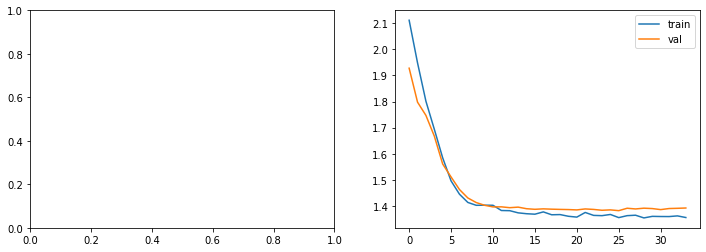

Fold 1


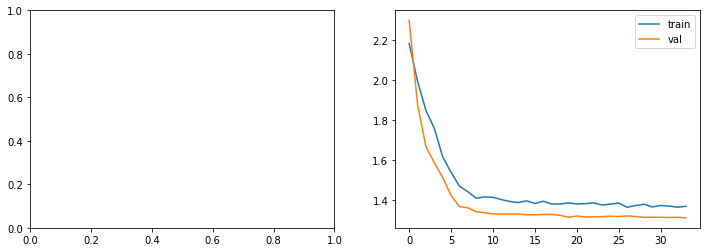

Fold 2


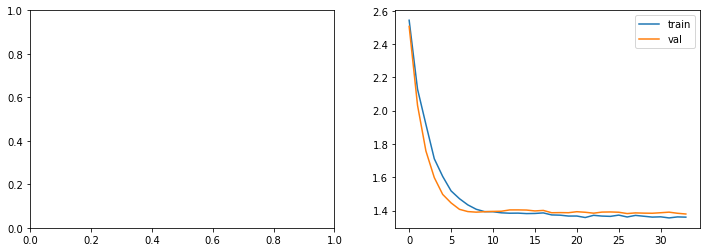

Fold 3


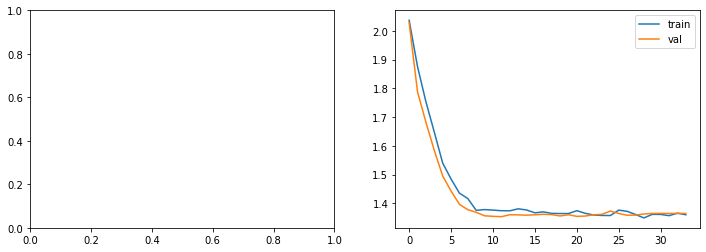

Fold 4


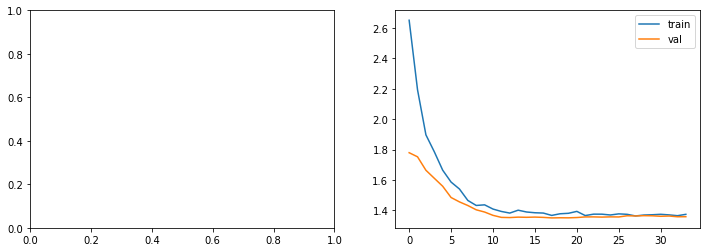

[1.3880826115608216, 1.3173475861549377, 1.3859716773033142, 1.3644867181777953, 1.3606152653694152]


In [239]:
models = []
scores = []

kf = KFold(n_splits=5,shuffle=True)
for i,(t,v) in enumerate(kf.split(train_tensor_field,output_values)):
    print(f'Fold {i}')
    #val_model_id[v] = i
    
    # Assign training and validation data sets
    X_train = train_tensor_field[t]
    y_train = output_values[t]
    
    X_val = train_tensor_field[v]
    y_val = output_values[v]
    
    # Augment and standardize training data
    # X_train, y_train = Augment_Training(X_train_raw,y_train_raw)
    X_train = standardize_features(X_train)
    
    # Standardize validation data
    X_val = standardize_features(X_val)
    
    # Create NN and train
    model_cur = create_NN_field(drop_rate=0.25,learning_rate=0.0008)
    history = model_cur.fit(
        X_train,
        y_train,
        batch_size = 16,
        epochs=34,
        verbose=0,
        validation_data = (X_val,y_val)
    )
    plot_history(history)
    
    # Save models and statistics to appropriate lists
    models.append(model_cur)
    scores.append(np.mean(history.history['val_loss'][-10:]))
    
print(scores)

### Check Return length prediction

73 54 3942


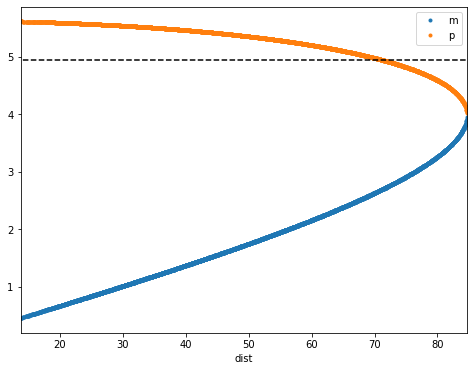

73 54 3774


In [281]:
#i=19
#bad_ids =[44,61,419,685,917,1077,1903,2681,3126,3603,3609,3788,3825,4156,4418,4421,4567,4569,4663,5044,5224]
#check_id = bad_ids[i]
check_id = 61#np.random.randint(len(data))

step_size = 1
yardline = fb_x.iloc[check_id,0]

x_yards = np.arange(yardline,110,step_size)
y_yards = np.arange(0,161/3, step_size)

# Create array of new x and y locations for the football to land.
# Zipping expanded_x and expanded_y give all possible locations
expanded_x = x_yards.repeat(len(y_yards))
expanded_y = np.tile(y_yards,len(x_yards))

print(len(x_yards),len(y_yards),len(expanded_x))

def calc_const(dx, dy, ht):
    g = 32.1/3
    dist = np.sqrt(dx**2 + dy**2)
    v_const = (dist/ht)**2 + (g*ht/2)**2
    return np.sqrt(v_const)

def calc_time(del_x, v_const):
    g = 32.1/3
    p1 = 2/g**2*v_const**2
    p2 = 2/g**2*np.sqrt(v_const**4 - g**2 * del_x**2)
    return [np.sqrt(p1-p2),np.sqrt(p1+p2)]


dx = punter.iloc[check_id,0] - fb_x.iloc[check_id,1]
dy = punter.iloc[check_id,1] - fb_y.iloc[check_id,1]
ht = data.iloc[check_id]['hangTime']
v_const = calc_const(dx,dy,ht)

mod_ht = pd.DataFrame(expanded_x,columns=['x'])
mod_ht['y'] = expanded_y
mod_ht['dist'] = np.sqrt((mod_ht['x']-punter.iloc[check_id,0])**2 + (mod_ht['y']-punter.iloc[check_id,1])**2)
mod_ht = mod_ht[mod_ht['dist']<= 3*v_const**2/32.1]
mod_ht['m'],mod_ht['p'] = calc_time(mod_ht['dist'],v_const)

fig,ax=plt.subplots(figsize=(8,6))
mod_ht.plot(x='dist',y='m',ax=ax,style='.')
mod_ht.plot(x='dist',y='p',ax=ax,style='.')
plt.plot(np.array([0,100]),ht*np.ones(2),'k--')
plt.xlim(mod_ht['dist'].min(),mod_ht['dist'].max())
plt.show()

# We have removed the landing locations that are out of range
expanded_x = mod_ht['x'].values
expanded_y = mod_ht['y'].values

print(len(x_yards),len(y_yards),len(expanded_x))

# Keep all the player data from this event the same.
# We only need to change where the ball lands, which only appears in the form (FB_land - P_return)_(x,y)
# Thus, adding the value (FB_land_new - FB_land_old)_(x,y) to the training tensor will update to the new landing position
new_fbland = np.tile(train_tensor_field[check_id],(len(expanded_y),1,1,1)) # Copy play data for each new landing spot

norm_delta_x = expanded_x - fb_x.iloc[check_id,1]
norm_delta_y = expanded_y - fb_y.iloc[check_id,1]

new_fbland[...,4] += np.tile(norm_delta_x[:,np.newaxis,np.newaxis],(1,10,11))
new_fbland[...,5] += np.tile(norm_delta_y[:,np.newaxis,np.newaxis],(1,10,11))
# new_fbland[...,8] = np.tile(expanded_x[:,np.newaxis,np.newaxis],(1,11,10))
# new_fbland[...,9] = np.tile(expanded_x[:,np.newaxis,np.newaxis],(1,11,10))
new_fbland[...,6] = np.tile(mod_ht['p'].values,(11,10,1)).T

model_pred = pd.DataFrame()
for i,model in enumerate(models):
    prob = model.predict(standardize_features(new_fbland))
    potential_land = pd.DataFrame(np.concatenate((np.array([expanded_x,expanded_y]).T,np.sinh(prob)),axis=1),columns=['x_land','y_land',f'ReturnYardage_{i}'])
    model_pred = pd.concat([model_pred,potential_land],axis=1)
    
model_pred = model_pred.T.drop_duplicates().T
model_pred['avg'] = model_pred.iloc[:,2:].mean(axis=1)

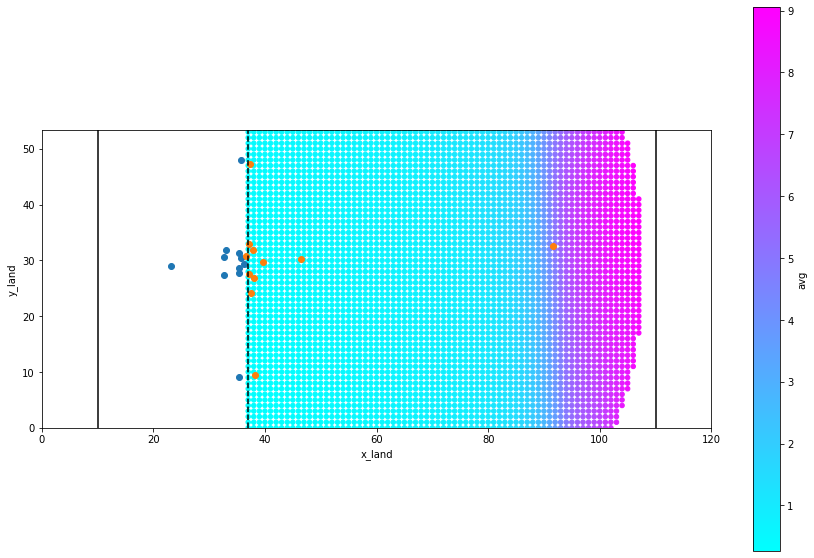

In [282]:
fig,ax = plt.subplots(figsize=(15,10))
#p_field_{int(val_model_id[check_id])}
model_pred.plot.scatter(x='x_land',y='y_land',c='avg',colormap='cool',ax=ax)#,vmin=0,vmax=1
plt.scatter(pd.concat([punt_team_x,punter['x_punt']],axis=1).iloc[check_id],pd.concat([punt_team_y,punter['y_punt']],axis=1).iloc[check_id])
plt.scatter(ret_team_x.iloc[check_id],ret_team_y.iloc[check_id])
#plt.scatter(fb_x[0,0],fb_y[0,0],marker='x')
plt.vlines(x=[10,110],ymin=0,ymax=55,colors='k')
plt.vlines(x=yardline,ymin=0,ymax=55,colors='k',linestyles='dashed')
plt.xlim(0,120)
plt.ylim(0,160/3)
plt.gca().set_aspect(1)
#plt.title('Hang Time: '+ str(norm_ht.iloc[check_id]))
plt.show()

In [283]:
# for i, model in enumerate(models):
#     model.save(f'./Models/ReturnModel{i}.h5')

In [285]:
#pd.DataFrame(norm_stats,columns=['mean','std']).to_csv('../ReducedData/return_training_statistics.csv',index=False)